## 读取数据集

In [2]:
import re
import collections
def read_book():
    with open("book.txt",'r') as f:
        lines = f.read().split(".")
        return [re.sub('[^A-Za-z]+', ' ', line) for line in lines]

lines = read_book()[1:-1]
print(f'# 文本总行数: {len(lines)}')
print(lines[-1])


# 文本总行数: 5184
 His soul swooned slowly as he heard the snow falling faintly through the universe and faintly falling like the descent of their last end upon all the living and the dead


## TF-IDF

In [3]:
import math
def TFIDF(lines):
    tf_idf = {}
    tf_dic = {}
    idf_dic = {}
    N = len(lines)
    words = [word for line in lines for word in line.split()]
    frequency = collections.Counter(words)
    for word,freq in frequency.items():
        tf = math.log(freq/len(words)+1)
        tf_dic[word] = tf
        idf = 0
        for line in lines:
            if word in line:
                idf+= 1
        idf = math.log(N/idf)
        idf_dic[word] = idf
        tf_idf[word] = tf*idf
    return tf_dic,idf_dic,tf_idf                

tf,idf,tf_idf = TFIDF(lines)
print("their:")
print("\ntf: ", tf['their'])
print("\nidf: ",idf['their'])
print("\ntf-idf: ",tf_idf['their'])

their:

tf:  0.0019930106825200846

idf:  3.817133789637615

tf-idf:  0.00760758841935614


In [4]:
## 使用 nltk 计算 tf-idf
from nltk.text import TextCollection
words = [line.split() for line in lines]
corpus = TextCollection(words)
tf_idf = corpus.tf_idf('their',corpus)
tf = corpus.tf('their',corpus)
idf = corpus.idf('their')
print("their:")
print("\ntf: ", tf)
print("\nidf: ",idf)
print("\ntf-idf: ",tf_idf)

their:

tf:  0.0019949980483714744

idf:  3.834833366737016

tf-idf:  0.007650485082470158


## FFNNLM（前馈神经网络语言模型）
### 构建词表

In [5]:
def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


class Vocab:
    def __init__(self,tokens=None, min_freq=0, reversed_tokens=None):
        if tokens is None:
            tokens = []
        if reversed_tokens is None:
            reversed_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(),key= lambda x:x[1], reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reversed_tokens
        self.token_to_idx = {tokens:idx for idx,tokens in enumerate(self.idx_to_token)}

        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token)-1
    
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list,tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs

In [6]:
BOS_TOKEN = "<bos>"
EOS_TOKEN = "<eos>"
PAD_TOKEN = '<pad>'

vocab = Vocab(words, reversed_tokens=[BOS_TOKEN,EOS_TOKEN,PAD_TOKEN])
print(list(vocab.token_to_idx.items())[:10])
print(vocab.idx_to_token[:10])
print(len(vocab))

[('<unk>', 0), ('<bos>', 1), ('<eos>', 2), ('<pad>', 3), ('the', 4), ('and', 5), ('of', 6), ('to', 7), ('a', 8), ('was', 9)]
['<unk>', '<bos>', '<eos>', '<pad>', 'the', 'and', 'of', 'to', 'a', 'was']
7680


In [7]:
vocab.token_to_idx[BOS_TOKEN]

1

### 构建NN

In [8]:
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NGramDataset(Dataset):
    def __init__(self, corpus,vocab, context_size=2):
        self.data = []
        self.bos = vocab.idx_to_token[vocab.token_to_idx[BOS_TOKEN]]
        self.eos = vocab.idx_to_token[vocab.token_to_idx[EOS_TOKEN]]
        for line in tqdm(corpus,desc="Dataset Construct"):
            if len(line) < context_size:
                continue
            for i in range(context_size,len(line.split())):
                context = line.split()[i-context_size:i]
                target = line.split()[i]
                self.data.append((vocab[context],vocab[target]))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i]
    
    def collate_fn(self, examples):
        inputs = torch.tensor([ex[0] for ex in examples])
        targets = torch.tensor([list(ex)[1] for ex in examples])
        return (inputs, targets)
    


class FFNNLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim):
        super(FFNNLM, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size*embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)
        self.activate = F.relu
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if "embedding" not in name:
                torch.nn.init.uniform_(param,a=-0.1,b=0.1)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((inputs.shape[0],-1))
        hidden = self.activate(self.linear1(embeds))
        output = self.linear2(hidden)
        log_probs = F.log_softmax(output, dim=1)
        return log_probs

In [9]:
embedding_dim = 64
context_size = 4
hidden_dim = 128
batch_size = 1024
num_epoch = 10

dataset = NGramDataset(lines,vocab,context_size)
dataloader = DataLoader(dataset,batch_size=batch_size,collate_fn=dataset.collate_fn,shuffle=True)
criterion = nn.NLLLoss()
device = torch.device('mps' if torch.backends.mps.is_available() else "cpu")
model = FFNNLM(len(vocab), embedding_dim, context_size,hidden_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
total_losses = []

for epoch in range(num_epoch):
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Training Epoch{epoch}"):
        inputs, targets = [x.to(device) for x in batch]
        optimizer.zero_grad()
        log_probs = model(inputs)
        loss = criterion(log_probs, targets)
        loss.backward()
        optimizer.step()
        total_loss+= loss.item()
    print(total_loss)
    total_losses.append(total_loss)

Dataset Construct:   0%|          | 0/5184 [00:00<?, ?it/s]

Training Epoch0:   0%|          | 0/51 [00:00<?, ?it/s]

392.50022315979004


Training Epoch1:   0%|          | 0/51 [00:00<?, ?it/s]

320.6475567817688


Training Epoch2:   0%|          | 0/51 [00:00<?, ?it/s]

301.7682890892029


Training Epoch3:   0%|          | 0/51 [00:00<?, ?it/s]

287.00041246414185


Training Epoch4:   0%|          | 0/51 [00:00<?, ?it/s]

272.3240647315979


Training Epoch5:   0%|          | 0/51 [00:00<?, ?it/s]

257.0916085243225


Training Epoch6:   0%|          | 0/51 [00:00<?, ?it/s]

240.79622268676758


Training Epoch7:   0%|          | 0/51 [00:00<?, ?it/s]

223.23432874679565


Training Epoch8:   0%|          | 0/51 [00:00<?, ?it/s]

205.04650783538818


Training Epoch9:   0%|          | 0/51 [00:00<?, ?it/s]

187.34725785255432


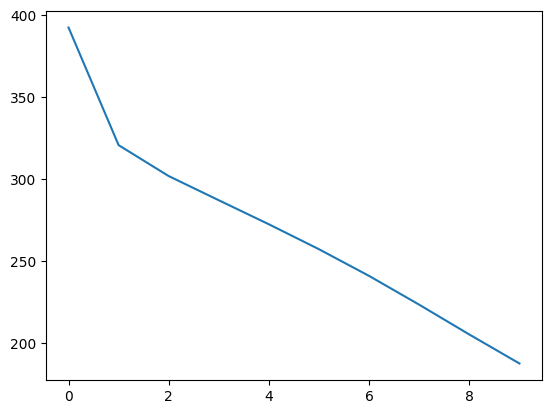

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(num_epoch),total_losses)

In [11]:
vector = model.embeddings.weight.data
vector

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


tensor([[ 1.0193, -1.0116, -0.8421,  ..., -2.1803,  0.0530,  0.5260],
        [ 1.2759, -1.2514,  0.0418,  ..., -1.7169, -0.7476, -1.1331],
        [ 2.7590, -1.8352,  0.3190,  ...,  0.5095, -0.0473,  0.0905],
        ...,
        [ 0.1545, -1.1630, -1.2295,  ..., -0.3445, -0.0695,  0.3267],
        [ 1.6703,  1.7223,  0.0913,  ...,  0.0137,  1.2121,  1.8182],
        [ 1.3987,  0.2023, -0.3567,  ..., -1.0573,  0.7072, -0.1821]],
       device='mps:0')

## Word2Vec
### CBOW

In [24]:
class CBOW(nn.Module):
    def __init__(self,vocab_size,embedding_dim):
        super(CBOW,self).__init__()
        self.embed = nn.Embedding(vocab_size,embedding_dim)
        self.linear1 = nn.Linear(embedding_dim,vocab_size)

    def forward(self,inputs):
        embed = self.embed(inputs)
        hidden = embed.mean(dim=-1)
        self.linear1.weight = self.embed.weight.T
        out = self.linear1(hidden)
        log_probs = F.log_softmax(out)
        return log_probs

vocab_size = len(vocab)
embedding_dim = 128

cbow = CBOW(vocab_size,embedding_dim)

class NGramDataset(Dataset):
    def __init__(self, corpus,vocab, context_size=5):
        self.data = []
        self.bos = vocab.idx_to_token[vocab.token_to_idx[BOS_TOKEN]]
        self.eos = vocab.idx_to_token[vocab.token_to_idx[EOS_TOKEN]]
        for line in tqdm(corpus,desc="Dataset Construct"):
            if len(line) < context_size:
                continue
            for i in range(context_size,len(line.split())):
                target = line.split()[i-3]
                context = line.split()[i-context_size:i]
                del context[2]
                self.data.append((vocab[context],vocab[target]))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i]
    
    def collate_fn(self, examples):
        inputs = torch.tensor([ex[0] for ex in examples])
        targets = torch.tensor([list(ex)[1] for ex in examples])
        return (inputs, targets)
dataset = NGramDataset(lines,vocab,5)
dataloader = DataLoader(dataset,batch_size=batch_size,collate_fn=dataset.collate_fn,shuffle=True)
criterion = nn.NLLLoss()
device = torch.device('mps' if torch.backends.mps.is_available() else "cpu")
cbow.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
total_losses = []

for epoch in range(num_epoch):
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Training Epoch{epoch}"):
        inputs, targets = [x.to(device) for x in batch]
        optimizer.zero_grad()
        log_probs = cbow(inputs)
        loss = criterion(log_probs, targets)
        loss.backward()
        optimizer.step()
        total_loss+= loss.item()
    print(total_loss)
    total_losses.append(total_loss)


Dataset Construct:   0%|          | 0/5184 [00:00<?, ?it/s]

Training Epoch0:   0%|          | 0/47 [00:00<?, ?it/s]

TypeError: cannot assign 'torch.mps.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)